In [5]:
from unbalancedsinkhorn import DebiasedUOT
import numpy as np
import torch
import matplotlib.pyplot as plt

from imageio import imread
from random import choices, seed
import matplotlib.animation as animation

In [6]:
def load_image(fname):
    """
    Taken from geomloss example
    """
    img = imread(fname, mode='F')  # Grayscale
    img = (img[::-1, :]) / 255.0
    return 1 - img


def draw_samples(fname, n, dtype=torch.FloatTensor):
    """
    Taken from geomloos example
    """
    A = load_image(fname)
    # print('Dimension of loaded image', A.shape)
    seed(123456)

    xg, yg = np.meshgrid(np.linspace(0, 1, A.shape[0]), np.linspace(0, 1, A.shape[1]))

    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()

    dots = np.array(choices(grid, dens, k=n))
    # dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return dots  # torch.from_numpy(dots).type(dtype)

In [7]:
# Initialise Parameters and variables
m1, m2 = 20, 20
n1, n2 = 20, 20

# Epsilon set by grid size
ε = 1 / (0.5*(m1*m2+n1*n2))

# Convergence tolerance 
tol = 1e-7

# User defined rho parameter, proportional to the reach.
rho = 1.0

# Stepping for Euler GRadient flow
time_steps = 100
lr = 0.02 # learning rate

In [8]:
heart = draw_samples('/home/jacob/PhD_jobs/heart_star/heart_density.png', n1*n2)
# perturb
# heart[:, 0] += 0.2
# heart[:, 1] += 0.2
star = draw_samples('/home/jacob/PhD_jobs/heart_star/star_density.png', m1*m2)

/tmp/ipykernel_36788/886870344.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname, mode='F')  # Grayscale


In [9]:
heart_Start_solver = DebiasedUOT(pykeops=False)
heart_Start_solver.parameters(epsilon=ε, rho=rho)
heart_Start_solver.densities(heart, star)

output_star = np.zeros((n1*n2, 2, time_steps))

for t in range(time_steps):
    heart_Start_solver.sinkhorn_algorithm(aprox='balanced')
    heart_Start_solver.sinkhorn_divergence()

    #save current
    output_star[:,:, t] = heart_Start_solver.X_s.clone().cpu().numpy()
    # euler update
    heart_Start_solver.X_s += - (heart_Start_solver.barycentre_map_of_points('target') - heart_Start_solver.debias_g.barycentre_map_of_points('target')) * lr


Convergence in f, g updates below 1e-15 in 16 iterations
Convergence in f, g updates below 1e-12 in 10 iterations
f debias tensor(False, device='cuda:0') tensor(False, device='cuda:0')
Convergence in f, g updates below 1e-12 in 10 iterations
g debias? tensor(False, device='cuda:0') tensor(False, device='cuda:0')
Convergence in f, g updates below 1e-15 in 0 iterations
Convergence in f, g updates below 1e-12 in 10 iterations
f debias tensor(False, device='cuda:0') tensor(False, device='cuda:0')
Convergence in f, g updates below 1e-12 in 10 iterations
g debias? tensor(False, device='cuda:0') tensor(False, device='cuda:0')
Convergence in f, g updates below 1e-15 in 0 iterations
Convergence in f, g updates below 1e-12 in 9 iterations
f debias tensor(False, device='cuda:0') tensor(False, device='cuda:0')
Convergence in f, g updates below 1e-12 in 10 iterations
g debias? tensor(False, device='cuda:0') tensor(False, device='cuda:0')
Convergence in f, g updates below 1e-15 in 0 iterations
Conve

/tmp/ipykernel_36788/3292867439.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(heart_Start_solver.Y_t[:,0].cpu(), heart_Start_solver.Y_t[:,1].cpu(), cmap='terrain_r', label='Universe (Star)', s=1)


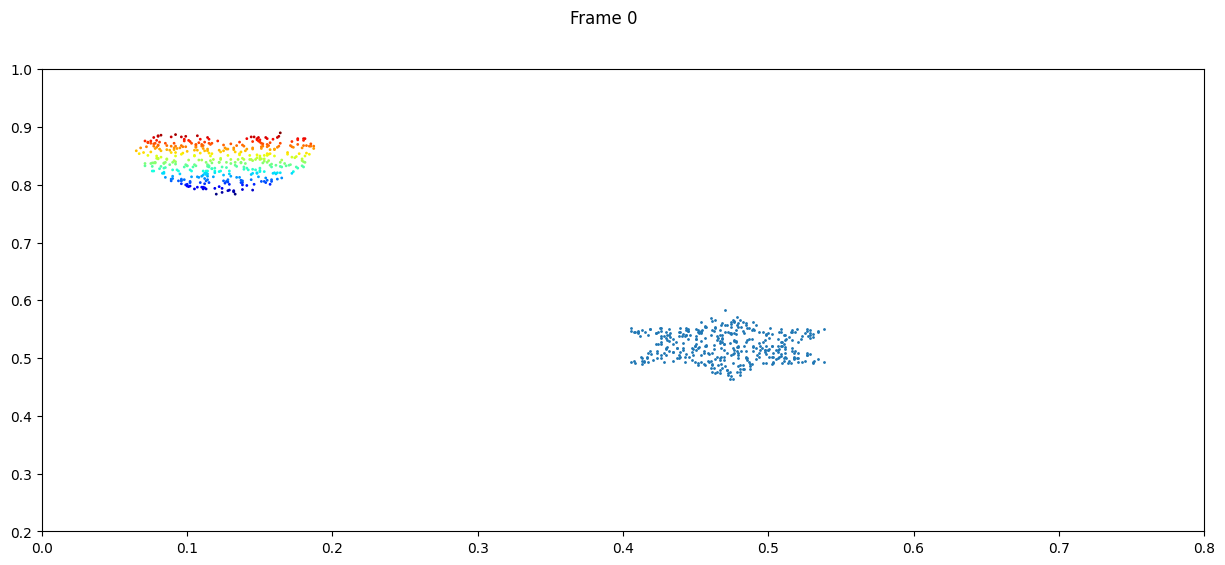

In [10]:

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

def function(i):
    ax.clear()

    ax.scatter(output_star[:,0, i], output_star[:,1,i], c=heart[:,1], cmap='jet', label='Geoverse (Heart)',s=1)
    ax.scatter(heart_Start_solver.Y_t[:,0].cpu(), heart_Start_solver.Y_t[:,1].cpu(), cmap='terrain_r', label='Universe (Star)', s=1)
    ax.set(xlim=[0,0.8],ylim=[0.2,1])
    # ax.legend()

    fig.suptitle('Frame {}'.format(i))

ani = animation.FuncAnimation(fig, function, frames=range(time_steps-1), interval=100)


ani.save('debias_gradflow_bias.gif')